# **Projet de Processus de Poisson :** Thinning Algorithms for Simulating Point Processes

La méthode du **thinning** permet de simplifier la représentation spatiale de données en sélectionnant certains points vérifiant une condition donnée, tout en préservant les caractéristiques importantes de ces données. C'est une généralisation de la méthode d'acceptation/rejet souvent utilisée pour générer des variables aléatoires. La méthode du thinning permet de créer un processus de Poisson non homogène en sélectionnant judicieusement des points à partir d'un processus de Poisson homogène.

In [1]:
#! pip install -U Cython numpy
#! pip install hawkeslib

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import math
import pandas as pd
from scipy.stats import kstest
import statsmodels.api as sm
#from hawkeslib import UnivariateExpHawkesProcess as UVHP
from datetime import datetime

## **Processus de comptage et processus ponctuel**

Pour commencer, nous définissons dans cette partie les processus de comptage et les processus ponctuels. En effet, ces deux derniers sont utilisés pour définir les processus de Poissons et de Hawkes, qui nous intéressent dans ce projet.

**Définition:** Le **processus N(t) de comptage** compte le nombre d'événements qui arrivent dans l'intervalle de temps $[0,t]$. Il  est défini par le processus $\{N(t) ; t \geq 0\}$ et vérifie les propriétés suivantes : 
- $\forall t \geq 0$, $N(t)$ est constant par morceaux et à valeurs dans $\mathbb{N}$ ;
- $t \mapsto N(t) \text{ est croissante}$ ;
- $\forall 0<a<b$, $N(b)-N(a)$ représente le nombre d'événements arrivant dans l'intervalle de temps $]a,b]$.


**Définition:** Un **processus ponctuel sur $\mathbb{R}^+$** est un sous-ensemble aléatoire et dénombrable de $\mathbb{R}^+$ où chaque point correspond au moment d'occurance d'événement. Il est aussi défini comme l'intersection entre $\mathbb{R}^+$ et la séquence croissante des temps auxquels les événements se produisent. Cette séquence est aussi appelée comme l'ensemble des temps d'arrivée et notée $0 < T_1 < T_2 < ... < T_n < ...$ avec  $(T_n)_n \in \mathbb{R}^+$ 

**Lien entre processus ponctuel $(T_n)_n$ et processus de comptage $(N_t)_t$:**   
$ \forall n \in \mathbb{N}^+$ et pour tout ($t_1$, $t_2$, ..., $t_n$) dans $\mathbb{R}^+$ : 

$ \{T_1 \leq t_1, T_2 \leq t_2, \ldots, T_n \leq t_n \} = \{ N_{t_1} \geq 1, N_{t_2} \geq 2, \ldots, N_{t_n} \geq n \}$

Il est donc équivalent de définir un processus ponctuel grâce aux temps d'arrivée ou grâce au processus de comptage. On choisira pour la suite de le définir avec $(N_t)_t$.

***Propriété :*** Un processus de ponctuel N est à *accroissements indépendants* si le nombre de points entre intervalles disjoints est indépendant. Autrement dit, $\forall n \in \mathbb{N}^*$, $\forall \quad  0<t_1<t_2<...<t_n$, les variables aléatoires $N_{t_1}-N_0, N_{t_2}-N_{t_1}, ..., N_{t_n}-N_{t_{n-1}}$ sont indépendantes.



***Propriété:*** Un processus ponctuel est à *accroissements stationnaires* si la distribution du nombre de points de tout intervalle de temps dépend uniquement de la longueur de cet intervalle. Autrement dit, $\forall s \geq 0$, le nombre de points dans l'intervalle $(t,s+t]$ soit $N_{t+s}-N_{t}$ a la même distribution $\forall t$.

## **Processus de poisson homogène sur $\mathbb{R}_+$**

Dans cette partie, nous donnons quelques définitions et propriétés des processus de Poisson homogènes avant de les simuler.

**Définition :** Un processus de ponctuel $\{N(t) ; t \geq 0\}$ est appelé processus de Poisson homogène d'intensité $\lambda > 0$ si :
- $N(0) = 0$ ; 
- Le processus est à accroissements indépendants et stationnaires;
- $\mathbb{P}(N_{t+h} - N_t = 1) = \lambda h + o(h)$;
- $\mathbb{P}(N_{t+h} - N_t > 1) = o(h)$.

***Proposition:*** Le nombre de points dans un intervalle de longueur t d'un processus de poisson homogène suit une loi de Poisson de paramètre $\lambda t$. 
$$ \mathbb{P}\{N(t + s) - N(s) = n \} = e^{-\lambda t}\frac{{(\lambda t)^n }}{{n!}}$$

***Proposition:*** Les temps d'arrivée d'un processus de poisson homogène sont distribués suivant une variable aléatoire qui suit une loi exponentielle de paramètre $\lambda$.

***Proposition:***  
$$\mathbb{E}(N_t)=\lambda t \text{, avec } \mathbb{E}(N_t) \text{ l'espérance de } N_t $$ 
$\text{et :}$
$$ Var(N_t)= \lambda t \text { avec } Var(N_t)\text { la variance de } N_t$$

Ainsi, un processus de Poisson homogène se caractérise par l'indépendance et la stationnarité de ses événements et par son intensité $\lambda$ constante.

### *Algorithme 1: Simulation d'un processus de Poisson Homogène avec un taux λ sur [0,T]*

Nous allons maitenant simuler un processus de Poisson Homogène de taux $\lambda$ : 

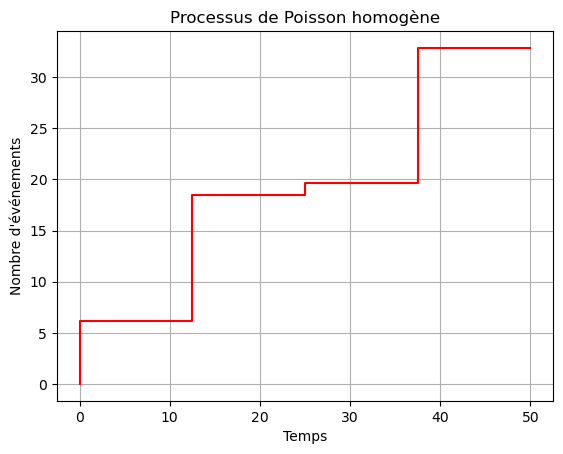

In [3]:
def Process_homogène(lamb,T):
    val=[0]
    t=0
    while True :
        u=npr.uniform(0,1)
        w=-1/lamb * np.log(u)## w~exp(lamb)
        #print(w)
        t=t+w
        #print(times)
        if t > T : 
            return val, len(val)
        else : 
            val.append(t)

#On simule un Poisson Homogène avec notre "Algo 1"
lamb = 0.1
T = 50
P,n= Process_homogène(lamb,T)

times=np.linspace(0,T,n) #création intervalle de temps

#Affichage
plt.step(times, P,color='red')
plt.xlabel('Temps')
plt.ylabel('Nombre d\'événements')
plt.title('Processus de Poisson homogène')
plt.grid(True)
plt.show()

## **Processus de poisson inhomogène sur $\mathbb{R}_+$**

Dans cette partie, nous définissions désormais les processus de Poisson inhomogènes avant d'également les simuler.

**Définition :** Un processus de ponctuel $\{N(t) ; t \geq 0\}$ est appelé processus de Poisson inhomogène avec pour intensité la fonction localement intégrable $\lambda (t) > 0$, $t>0$ si :
- $N(0) = 0$ ; 
- Le processus est à accroissements indépendants et stationnaires;
- $\mathbb{P}(N_{t+h} - N_t = 1) = \lambda(t) h + o(h)$;
- $\mathbb{P}(N_{t+h} - N_t > 1) = o(h)$.

La fonction $\Lambda$ : $t \mapsto \int_{0}^{t} \lambda (s) \,ds $ est appelée l'intensité cumulée du processus de Poisson inhomogène. 

La définition précédente est identique à celle d'un processus de Poisson homogène à la différence que l'intensité n'est maintenant plus constante, mais dépend du temps $t$.

***Proposition :*** Un processus de Poisson inhomogène N d'intensité la fonction $\lambda (t)$ suit une loi de Poisson de paramètre $\int_{0}^{t}\lambda (s) \,ds$ : 

$$\mathbb{P}(N(t)=n) = \frac{\exp^{-\int_{0}^{t}\lambda (s) \,ds} (\int_{0}^{t}\lambda (s) \,ds)^n} {n!} $$

***Proposition:***  $\mathbb{E}(N_t)=Var(N_t)=\Lambda(t)$

Ainsi, à la différence d'un processus de poisson homogène, un processus inhomogène a une intensité $\lambda(t)$ qui varie avec le temps mais conserve l'indépendance et la stationnarité de ces événements.

### *Algorithme 2: Simulation d'un processus de Poisson Inhomogène avec une fonction intensité $\lambda$ bornée sur [0,T]*

Nous allons mettre en place ci-dessous un algorithme de thinning pour simuler un processus de Poisson Inhomogène. En effet, cet algorithme transforme un processus de Poisson Homogène en un processus de Poisson Inhomogène en ajustant le taux d'acceptation des points générés selon la fonction d'intensité $\lambda(t)$. Les points finaux acceptés suivent un processus de Poisson Inhomogène puisqu'ils conservent les propriétés d'un processus de Poisson Homogène (notamment d'indépendance entre les événements) mais leur intensité est variable en fonction du temps.

Nous allons présenter l'idée globale de cet algorithme : 
- On simule une intensité $\lambda$ 
- Tout d'abord, nous trouvons le plus petit des majorants, soit ici $\lambda_{max} = sup_t(\lambda (t))$
- On génère des variables alétoires suivant une loi exponentielle de paramètre $\lambda_{max}$, on obtient alors le vecteur des $\tau_i$ tels que $\tau_i \sim \mathcal{E}(\lambda_{max})$
- Dans un même temps, on simule une variable aléatoire $D_i$ pour chaque $\tau_i$ telle que : $D_i \sim \mathcal{U}([0,1])$
- On calcule $D_i\lambda_{max}$ et on impose une condition :  $D_i\lambda_{max} < \lambda(\tau_i)$
- On sélectionne les points $D_i\lambda$ qui sont en dessous de la courbe de $\lambda(t)$, ces points représentent les points dans le Poisson inhomogène.


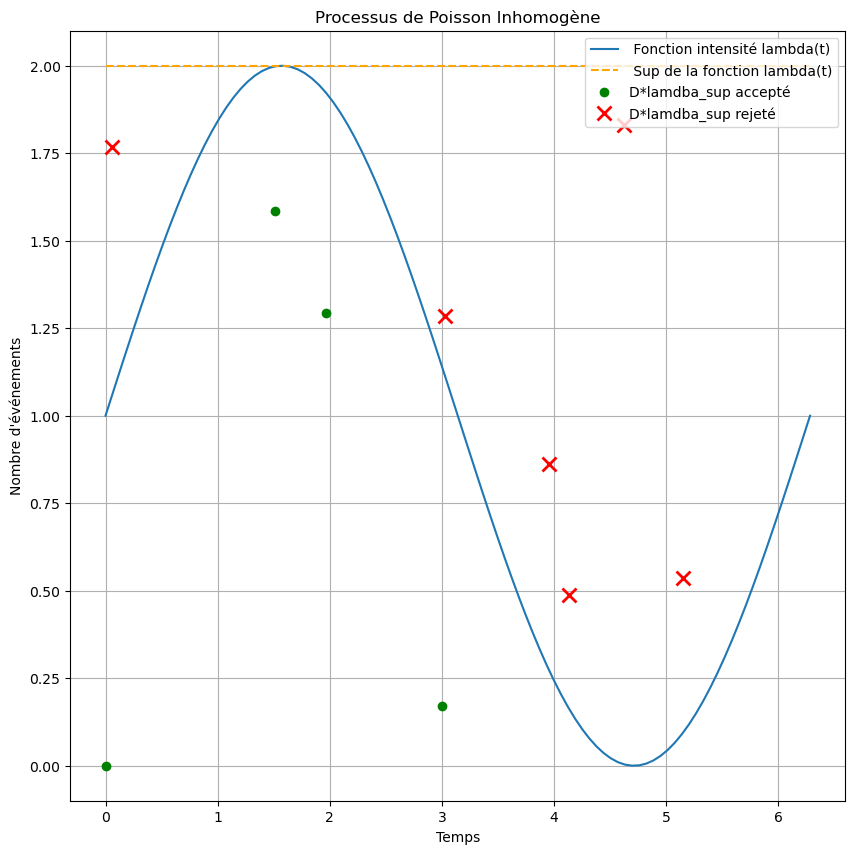

In [4]:
lamb = 0.4
Tmax = 2*np.pi
times=np.linspace(0,Tmax, 10)

#### fonction densité ####
def lambd(t) :
    return 1+np.sin(t)

#### fonction qui calcule le sup ####
def sup(fonction, debut=0, fin=Tmax, pas=0.01):
    t = debut
    sup = fonction(debut)
    while t <= fin: 
        if fonction(t) > sup:
            sup = fonction(t)
        t += pas
    return sup

 
#### fonction qui génère le process ####
def Process_inhomogène(lamb,Tmax):
    T=[0] ; S=[0]
    T_R=[] ; R=[]
    t=0 ; s=0
    lamb_max= sup(lamb)
    
    while s<Tmax :
        u=npr.uniform(0,1)
        w=-math.log(u)/lamb_max    # w~exp(lamb_max)
        s=s+w
        D=npr.uniform(0,1)
        if D <= lamb(s)/lamb_max : #condition d'acception des temps tau par rapport au sup de notre fonction lambda 
            t=s
            T.append(t)            #tau accepté
            S.append(D*lamb_max)   #valeur de D*lamdba_max pour les tau acceptés
        else :
            T_R.append(s)          #tau refusé                                                                                                                             
            R.append(D*lamb_max)   #valeur de D*lamdba_max pour les tau refusés
            t=s                    #pour bien s'assurer qu'on ne dépasse pas tmax même dans ce cas où on incrément pas les tau acceptés 
    if t<=Tmax :
        return T,S,T_R,R
    else : 
        return T[:-1],S[:-1],T_R[:-1],R[:-1] #on renvoie tous les points sauf le dernier élémént qui est supérieur à Tmax
        
                                        
fig = plt.figure(figsize = (10, 10))


x=np.linspace(0,Tmax,100)
#Application de la fonction rate: 
plt.plot(x, lambd(x), label=" Fonction intensité lambda(t)")
plt.hlines(2,0,Tmax, color='orange', linestyle='--', label=" Sup de la fonction lambda(t)")



#Applications de la fonction de simulation/thinning
T,D,T_R,R= Process_inhomogène(lambd,Tmax)

plt.plot(T,D, "o",color='green', label="D*lamdba_sup accepté") #on affiche les intensité D des taus accepté T en point vert
plt.plot(T_R,R, "x",color='red', markersize=10, markeredgewidth=2, label="D*lamdba_sup rejeté") #on affiche les intensité R des taus refusé T_R en croix rouge
plt.xlabel('Temps')
plt.ylabel('Nombre d\'événements')
plt.title('Processus de Poisson Inhomogène')
plt.legend()
plt.grid(True)
plt.show()

## **Processus de Hawkes sur $\mathbb{R}_+$**

Nous allons maitenant nous intéresser aux processus de Hawkes. Dans un premier temps nous allons énoncer des définitions importantes pour comprendre la définition du processus de Hawkes. Enfin, nous simulerons l'algorithme de thinning dans le cas des processus de Hawkes.

***Définition :*** Un processus ponctuel est dit **auto-excitant** si l'intensité λ(.) dépend non seulement de l'instant t, mais aussi de tout le passé du processus ponctuel.

On définit l'entièreté du passé par l'écriture mathématique suivante : 

***Définition :*** Pour tout $N(t)$, la filtration naturelle $F^{N} = (\mathcal{F}_t^N; t\geq0)$ est définie par : 

$$ \mathcal{F}_t^N = σ \{ N(s) ; s \leq t \} $$

Autrement dit, $\mathcal{F}_t^N$ est l'algèbre σ générée par $N$  jusqu'à l'instant $t$, et représente l'histoire interne de $N$ jusqu'à l'instant $t$.

Avec cette définition, nous pouvons définir l'intensité λ(.) pour un processus ponctuel auto-excitant.
Il est plus approprié de l'appeler processus d'intensité, car λ(.) est lui-même un processus aléatoire dont la trajectoire de l'échantillon dépend de la réalisation de $N(.)$. 

***Définition :*** Soit $N(t)$ un processus ponctuel avec un filtrage naturel $\mathcal{F}_t^N$. On appelle la **fonction d'intensité stochastique du processus ponctuel** le processus continu à gauche définit tel que : 
$$ λ(t\vert \mathcal{F}_{t^{-}}^N) = \lim\limits_{h \to 0^+} \frac{P \{N(t+h) - N(t) > 0 \vert \mathcal{F}_{t^{-}}^N \}}{h}$$

La raison de l'utilisation de la continuité à gauche est liée à la prévisibilité : si l'intensité conditionnelle présente une discontinuité en un point du processus, alors sa valeur à ce point doit être définie par l'historique avant le processus.
discontinuité à un point du processus, sa valeur à ce point doit être définie par l'histoire avant ce point, et non par ce qui se passe au point lui-même. 
<br> Le processus de Hawkes présenté ci-dessous est un exemple de processus ponctuel auto-excitatif.

**Définition :** Un processus est dit simple si 
$$ P(N({t}) = 0 \text{ ou } 1 \text{ pour tout } t) = 1 $$


Nous pouvons désormais définir les processus de Hawkes.

**Définition** : (Hawkes, 1971) Un **processus de Hawkes** est un processus ponctuel univariant simple N(t) qui vérifie : 
- N(t) = 0 ;
- λ(t) est processus stochastique continu à gauche, donné par l'intégrale de Stieltjes :
$$ \lambda(t) = \mu + \int_{0}^{t} \alpha \exp(-\beta (t-s)) \, dN(s) = \mu + \sum_{k: t_k < t} \alpha \exp^{-\beta (t-s)} $$
avec $\mu>0$ et $0 < \alpha < \beta$ ;
- λ(t) est l'intensité stochastique du processus de ponctuel telle que :  
$$ P(N(t+h) - N(t) = 1 \,|\, \mathcal{F}_{t^-}^N) = \lambda(t)h + o(h) $$ 
- Le processus de ponctuel est ordonné tel que : 
$$ P(N(t+h) - N(t) \geq 2 \,|\, \mathcal{F}_{t^-}^N) = o(h) $$

Ce processus est dit Hawkes univariant avec une décroissance exponentielle sur $[0,\inf)$.




**Propriété :** 
$$ \mathbb{E}(H_t) = \frac{1}{(\alpha - \beta)} \big( \mu + \frac{\beta \mu}{(\alpha - \beta)} ( \exp((\alpha - \beta)t) - 1) - \beta\mu t\big) $$
avec $\mu>0$ et $0 < \alpha < \beta$ 

***Preuve:***

$$\text{Soit   }\quad \lambda_t = \mu + \sum_{s<t} \alpha \exp(- \beta (t-s)) \quad \text{ tel que } \quad \Delta_sH = H_s - H_s^- $$ avec $H_s$ un processus de Hawkes. 


On pose également: 
$$ \phi(t-s) = \alpha \exp(- \beta (t-s)) \quad \text{ tel que }\quad  \phi(u) = \alpha \exp(- \beta (u))$$

On cherche ici à calculer : 
$$ \mathbb{E} (H_t) = \int_{0}^{t} \mathbb{E}(\lambda_s)ds $$

Il nous faut calculer $\mathbb{E}(\lambda_s)$ en premier lieu.

On pose : $$ f_t = \mathbb{E}(\lambda_t) = \mu + \int_{0}^{t} \phi(t-s)\mathbb{E}(\lambda_s)ds $$
$$ \Leftrightarrow f_t = \mu + \int_{0}^{t} \phi(t-s)f_sds $$

On reconnaît le produit de convolution : $ f*\phi $ .

Or par la méthode des itérations de Picard, on pose la résolvante $\phi$ :
$$  \phi(s)= \sum_{n \leq 1} \phi^{(n)}(u) $$ 
$$ \text{ avec : }  \phi^{(n)} = \int_{0}^{u} \phi(u-s) \phi^{(n-1)} (s)ds \text{ et que : }  \phi^{(0)} = \phi$$ 

Cela nous permet d'obtenir l'expression de $f_t$ suivante  :
$$ \Leftrightarrow f_t = \mu ( 1 + \int_{0}^{t} \psi(s)f_sds) $$ 
avec $$\lVert \phi \rVert = \int_{0}^{\inf} \phi(u)du < 1 \Leftrightarrow {\lVert \phi \rVert}_1 <1 \Leftrightarrow \alpha < \beta $$ 

D'où : 
$$f_t = \mu + \alpha e^{- \beta t}+ \int_{0}^{t} e^{\beta s}f_sds $$ 

En dérivant, on obtient : 


$$f_t' = - \beta \alpha e^{- \beta t} \int_{0}^{t} e^{\beta s}f_sds + \alpha e^{- \beta t} \alpha e^{\beta t}f_t 
 = (- \beta (f_t-\mu) + \alpha f_t ) $$ $$ \quad \text{car } \quad \alpha e^{- \beta t} \int_{0}^{t} e^{\beta s}f_sds 
 = (\alpha - \beta) f_t + \beta \mu$$

On obtient alors une équation différentielle d'ordre 1 à coefficient constant définie par : 
$$ ft'(\beta- \alpha ) f_t=  \beta \mu$$

Les solutions sont de la forme : 
$$ f_t(t) = C\exp(((\alpha - \beta)t) - \frac{\beta \mu}{(\alpha - \beta)} \text{ avec C une constante.} $$

On peut déterminer cette constante car on sait que $ f_t(0) = \mu $
$$ \text{D'où : } C = \mu + \frac{\beta \mu}{(\alpha - \beta)} $$


Ainsi, on peut conclure le calcul de l'espérance :
$$ 
\mathbb{E}(H_t) = \int_{0}^{t} \mathbb{E}(\lambda_s) \, ds = \int_{0}^{t} f_s \, ds
$$
$$
= C \exp((\alpha - \beta)t) - \frac{\beta \mu}{(\alpha - \beta)} \, t 
$$
$$
= C \int_{0}^{t} \exp((\alpha - \beta)t) \, dt - \int_{0}^{t} \frac{\beta \mu}{(\alpha - \beta)} \, dt
$$

$$
= C (\frac{\exp((\alpha - \beta)t)}{(\alpha - \beta)}  - \frac{1}{(\alpha - \beta)})- \beta\mu t
$$


En remplaçant par la valeur de $C$, on obtient : 
$$
\mathbb{E}(H_t)= \frac{1}{(\alpha - \beta)} \big[ \mu + \frac{\beta \mu}{(\alpha - \beta)} ( \exp((\alpha - \beta)t) - 1) - \beta\mu t\big]
$$ 

Ainsi, on voit que l'espérance $ \mathbb{E}(H_t)$ est croissante en $t$. En comparant avec l'espérance d'un processus de Poisson on voit qu'en moyenne le processus de Hawkes réalise un petit plus de sauts qu'un processus de Poisson mais c'est de l'ordre d'une constante. 

En conclusion, la différence entre un processus de Hawkes et un processus de Poisson homogène ou inhomogène est la dépendance temporelle entre ses événements. Les événements du présent d'un tel processus influent sur les événements du futur. L'intensité du processus est conditionnée par son passé.

### Algorithme 3 : Simulation of a Univariate Hawkes Poisson with Exponential Kernel

On souhaite simuler un processus de Hawkes, afin d'avoir un aperçu plus visuel de ce processus aléatoire. 

On réalise l'algorithme suivant, qui ressemble beaucoup à l'algorithme 2 dans son idée générale. Cependant, dans cet algorithme le majorant de $\lambda$ change après chaque $\tau_i$. 

Nous allons présenter, en quelques mots, les étapes principales de l'algorithme : 
- On simule une intensité $\lambda(t) = \mu $
- On trouve le plus petit des majorants, soit ici $\lambda_{max} = \mu$ pour notre première expression de $\lambda$
    - On génère une variable aléatoire suivant une loi exponentielle de paramètre $\lambda_{max}$ tel que $\tau \sim \mathcal{E}(\lambda_{max})$
    - Dans un même temps, on simule une variable aléatoire $D$ pour chaque $\tau$ telle que : $D \sim \mathcal{U}([0,1])$
    - On calcule $D\lambda_{max}$ et on impose une condition :  $D\lambda_{max} < \lambda(\tau)$
    - On sélectionne le point $D_i\lambda$ il est représenté en dessous de la courbe de $\lambda(t)$, soit s'il respecte la condition, on range le $\tau$ associé dans un tableau T.
    - On recalcule alors  $\lambda_{max}$ tel que à $\lambda_{max}=\lambda(\tau)$
    
On réitère ces étapes jusqu'à ce que les valeurs des $\tau$ arrivent au délà d'une certaine valeur appelée $T_{max}$.

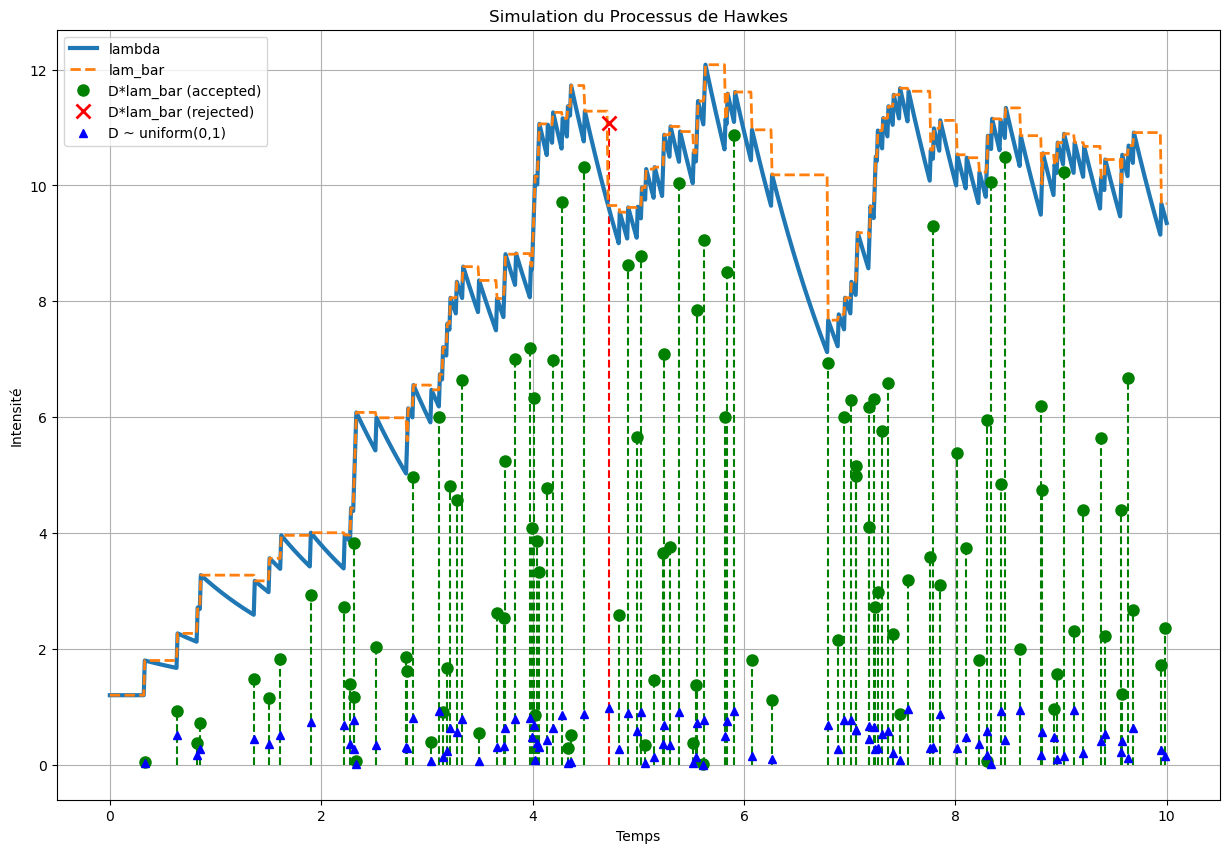

In [5]:
# fonction densité ####
def lam(su,times,mu=1.2,alpha=0.6,beta=0.8) :
    if times == []:
        return mu
    else : 
        return mu + np.sum(alpha * np.exp(-beta * (su - np.array(times))))    


def Hawkes_Process(mu, alpha, beta, Tmax):
    T = []                  # Pour stocker les tau
    S = []                  # Pour stocker le critère d'acceptation du tau
    s = 0                   # Initialisation de s
    T_R = [] ; R = []       # Pour stocker les tau refusé et leur intensité
    I = []                  # Pour stocker les valeurs de la variable aléatoire D suivant une loi uniforme
    while s < Tmax:  # On boucle sur la fenêtre de temps choisie
        if T == []:  # Si jamais on n'a pas encore eu de tau
            lambda_bar = mu  # On fait prendre la valeur du paramètre mu à lamdba_bar
        u = np.random.uniform(0, 1)
        w = -np.log(u)/lambda_bar   # w~exp(lamb_bar)
        s += w                      # On incrémente le pas de temps pour ne pas dépasser Tmax, la limite de la fenêtre de temps choisie
        D = np.random.uniform(0, 1) # On simule une uniforme sur (0,1)
        I.append(D) 
        l=lam(s,T) 
        if D * lambda_bar <= l: #Si le creitère d'acceptation est validé alors
            t=s
            T.append(t)              # On conserve le tau accepté
            S.append(D*lambda_bar)   # On conserve la valeur de D*lamdba_max pour les tau acceptés
            lambda_bar= mu + alpha * np.sum(np.exp(-beta * (s - np.array(T)))) #on met à jour le lambda_bar, i.e. le sup de lambda
        else :                  
            T_R.append(s)          # On conserve le tau refusé                                                                                                                             
            R.append(D*lambda_bar) # On conserve la valeur de D*lamdba_max pour les tau refusés
            t=s                    # On met à jour la valeur de t pour bien s'assurer qu'on ne dépasse pas Tmax même dans ce cas où on n'incrémente pas les tau acceptés
            lambda_bar= mu + alpha * np.sum(np.exp(-beta * (s - np.array(T)))) #on met à jour le lambda_bar, i.e. le sup de lambda 
    if t<=Tmax :
        return T,S,T_R,R,I
    else :
        return T[:-1],S[:-1],T_R[:-1],R[:-1], I[:-2] #on renvoie tous les points sauf le dernier élémént qui est supérieur à Tmax


# Application de l'algorithme de Thinning d'Ogata : On donne à nos paramètres la valeur indiquée dans le papier d'Ogata
mu = 1.2
alpha = 0.6
beta = 0.8
Tmax = 10
TH,DH,TH_R,RH, D= Hawkes_Process(mu, alpha, beta, Tmax) #On utilise notre algorithme avec ces paramètres

# On veut tracer la fonction d'intensité du processus de Hawkes, lamdba(t):
times=np.linspace(0,Tmax,1000)
l=[] ; sup_l = []; brk2 = []
j=0; count =0
for i in times:
    count +=1
    if j < len(TH)-1:   # Pour s'assurer qu'on ne dépasse pas le nombre de temps de sauts du processus de Hawkes
        if i < TH[0]:   # Tant qu'on a pas eu le 1er saut de temps accepté
            temp = mu   # Notre fonction lamdba reste constante et vaut mu en attendant d'avoir un premier évènement et donc un premier saut de temps
        elif i < TH[j]: # Sinon tant qu'on est entre deux temps de sauts tau on calcule notre lamdba
            temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:j]))))
        else :          # Dans le cas où on a dépassé un temps de sauts
            brk2.append(count-1) # On stocke l'indice de temps de sauts pour s'en servir pour l'affichage du sup de lambda donc de lamdba_bar
            j=j+1                # On passe au temps de sauts suivant
            temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:j]))))
        l.append(temp)
    else: #Une fois qu'on a dépassé le dernier temps de sauts, on prend la dernière valeur du temps de sauts et on calcule lambda jusqu'à la fin de la fenêtre de temps
        temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:-1]))))
        l.append(temp)


        
# On veut tracer le sup de la fonction lambda(t) précédente, lamdba_bar:
brk=[] # Pour stocker les temps où l'on doit recalculer le sup de lamdba
b=0
j=0
i=0

brk_rejete = [int(x*100) for x in TH_R] # On récupère les temps tau des points rejeté. On multiple par 100 car on a 1000 points sur l'intervalle [0,Tmax=10] donc on multiple par 100 pour arriver à [0,1000] 
#print(brk_rejete)
#print(brk2)
brk=brk2+brk_rejete # On concatène la liste des tau acceptés et celle des tau rejetés
brk=sorted(brk)     # On la trie par ordre croissant

for j in range(len(brk)): # On parcourt la liste des temps tau acceptés comme refusé
    while i < brk[j]:     # Tant qu'on est entre deux temps de saut on garde le même sup
        sup_l.append(max(l[b:brk[j]])) # On prend le max de lamdba sur l'intervalle du dernier temps de saut au prochain 
        i+=1
    b=brk[j]    # On actualise le dernier temps de saut, tau
while i < len(l): # Quand on a dépassé le dernier temps de saut tau, on boucle jusqu'au dernier point de lamdba
    sup_l.append(max(l[brk[-1]:len(l)-1])) # On calcule le sup sur ce dernier intervalle
    i+=1


fig = plt.figure(figsize = (15, 10))

#On veut afficher des lignes verticales à chaque tau accepté et refusé
count=0
for i in TH: # On parcourt la liste des tau acceptés
    if count < len(DH):
        plt.plot([i, i], [0, DH[count]], 'g--') #on trace une ligne en pointillée verte verticale partant du point (x=tau accepté, y=0), jusqu'au point (x=tau accepté, y=D*lamdba_bar) 
        count+=1
    #plt.axvline(x=i, linestyle='--', color='green', linewidth=1)
count=0
for j in TH_R:  # On parcourt la liste des tau refusés
    if count < len(RH):
        plt.plot([j, j], [0, RH[count]], 'r--') #on trace une ligne en pointillée rouge verticale partant du point (x=tau refusé, y=0), jusqu'au point (x=tau refusé, y=D*lamdba_bar) 
        count+=1
    #plt.axvline(x=j, linestyle='--', color='red', linewidth=1)

plt.plot(times, l,label="lambda", linewidth=3)                        # On affiche la fonction d'intensité du Processus de Hawkes lamdba en bleu
plt.plot(times, sup_l, linestyle='--', label="lam_bar",linewidth=2)   # On affiche le sup de lamdba ci-dessus en pointillé orange

plt.plot(TH,DH, "o",color='green', markersize=8, label="D*lam_bar (accepted)")                        # On affiche le critère d'acceptation des tau acceptés, représenté part un cercle vert
plt.plot(TH_R,RH, "x",color='red', markersize=10, markeredgewidth=2, label="D*lam_bar (rejected)")    # On affiche le critère d'acceptation des tau refusés, représenté part une croix rouge
TH2=TH+TH_R
TH2=sorted(TH2)

plt.plot(TH2, D,"^",color='blue', markersize=6, label="D ~ uniform(0,1)")       # On affiche la variable aléatoire D suivant une uniforme(0,1) qui a été utilisée pour le calcul du critère d'acceptation
plt.xlabel('Temps')
plt.ylabel('Intensité')
plt.title('Simulation du Processus de Hawkes')
plt.legend()
plt.grid(True)
plt.show()

## **Cas pratique : Application de l'algo de Hawkes aux données financières du CAC40**

Nous souhaitons apporter un aspect plus concret aux notions abordées précédemment. En effet, les processus de Hawkes ont des applications dans plusieurs domaines. Ils permettent de représenter les phénomènes où l'occurrence d'un événement peut influencer la probabilité d'occurrence d'événements futurs. Ces processus sont ainsi largement utilisés dans des domaines tels que la finance, pour modéliser l'évolution des marchés boursiers, ainsi que dans la sismologie et la neurobiologie pour étudier les comportements épidémiques et les activités neuronales.
<br> Dans cette partie, nous allons nous intéresser à une application dans le cadre de la finance et analyser l'évolution du CAC40 sur différentes périodes de temps. Pour cela, nous avons tout d'abord récupéré les données associées sur des périodes de 1an, 2ans et 5ans. Ces données répertorient plusieurs informations importantes triées par ordre chronologique.

In [6]:
#Chargement des données
CAC40_1an = pd.read_csv('^FCHI_1an.csv')
CAC40_2an = pd.read_csv('^FCHI_2ans.csv')
CAC40_5an = pd.read_csv('^FCHI_5ans.csv')
display(CAC40_1an)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-05-15,7443.379883,7455.629883,7397.859863,7418.209961,7418.209961,48638700
1,2023-05-16,7394.850098,7427.569824,7377.810059,7406.009766,7406.009766,61261800
2,2023-05-17,7378.830078,7422.580078,7354.540039,7399.439941,7399.439941,57783800
3,2023-05-18,7440.750000,7481.779785,7426.390137,7446.890137,7446.890137,59991600
4,2023-05-19,7469.779785,7523.560059,7463.959961,7491.959961,7491.959961,67973200
...,...,...,...,...,...,...,...
251,2024-05-08,8093.620117,8157.479980,8089.279785,8131.410156,8131.410156,53988400
252,2024-05-09,8123.919922,8191.919922,8114.879883,8187.649902,8187.649902,39071500
253,2024-05-10,8232.650391,8259.190430,8211.200195,8219.139648,8219.139648,57091000
254,2024-05-13,8211.070313,8223.809570,8186.770020,8209.280273,8209.280273,48113100


### Processus de Comptage

On regarde la valeur de l'indice du CAC40 à l'ouverture et à la fermeture du marché. On réalise un calcul de rendement comme suit : $$ \frac{\vert close-open \vert}{close} $$ et l'on veut savoir quand est-ce qu'il dépasse un seuil arbitraire *(ici de l'ordre de 1 et 2%, en effet pour le jeu de données sur 5 ans, nous avons essayé de prendre un seuil de 2% et sur les jeux de données de 1 et 2 ans nous avons essayé de prendre un seuil de 0,5%)*. On note que la valeur absolue dans notre calcul de rendement peut indiquer un rendement positif comme négatif, donc dans le contexte de la bourse une augmentation ou une diminution du cours sur la journée de plus de 1% par rapport à la valeur à l'ouverture.

Ensuite, on veut compter le nombre de fois où le rendement dépasse ce seuil dans notre plage de temps et on stocke les temps de dépassement. Cela nous donne le processus de comptage ci-dessous :

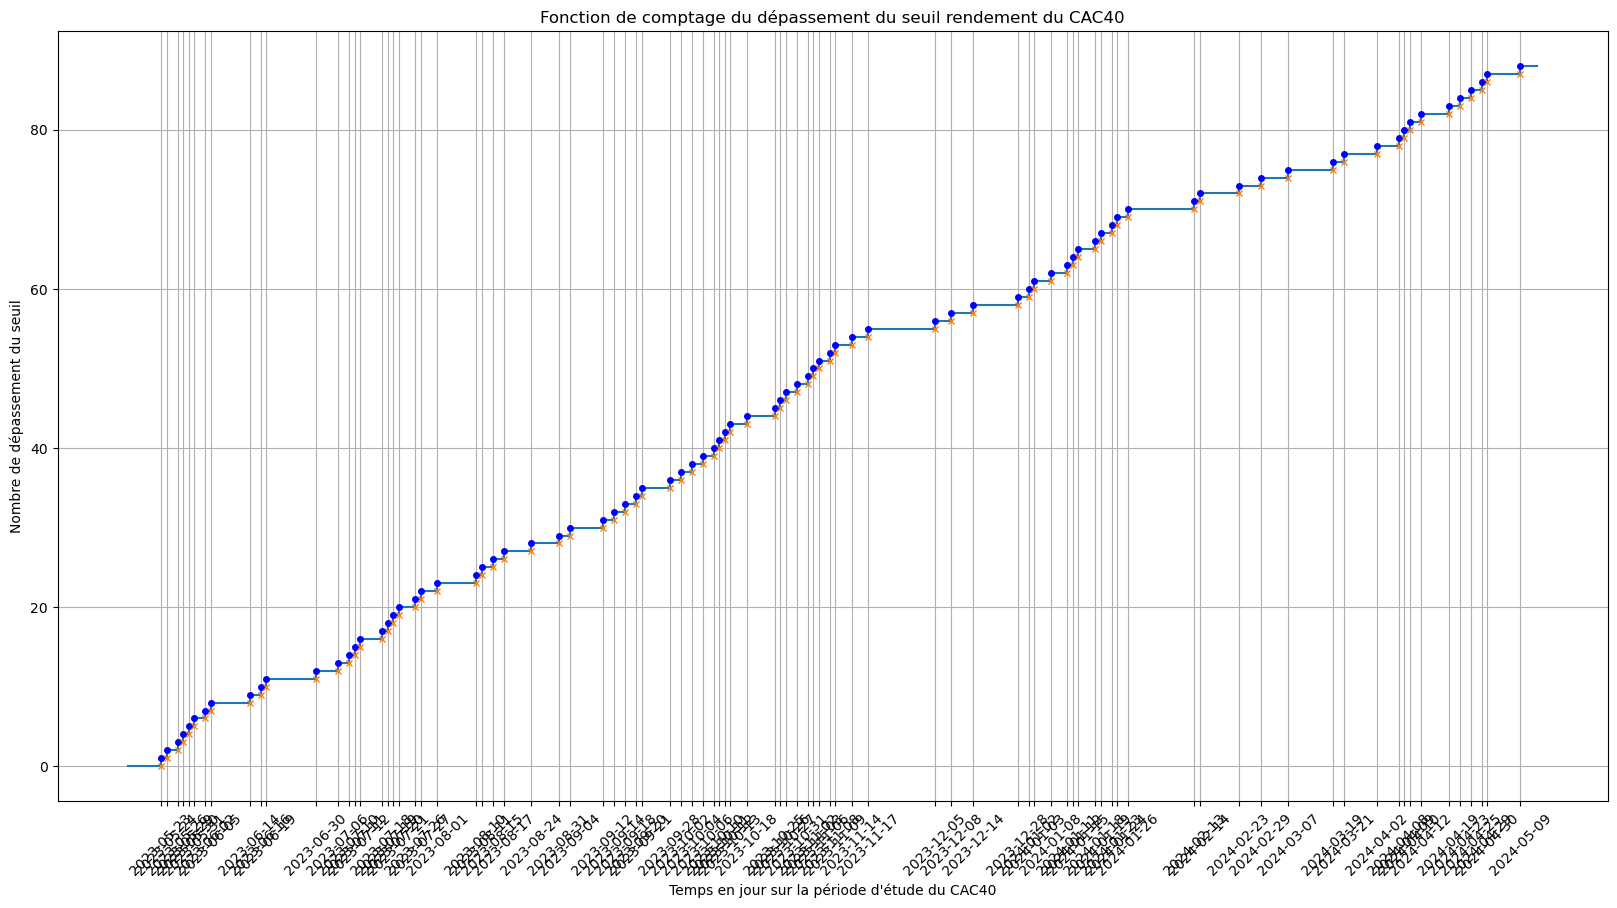

Temps de sauts 1 an: [8.0, 9.0, 11.0, 14.0, 15.0, 16.0, 18.0, 21.0, 30.0, 32.0]
---------------


NameError: name 'TH_2an' is not defined

In [8]:
# Fonction pour convertir une date en float
def date_to_float(date_str):
    # On convertit la chaîne de caractères en objet datetime
    date_obj = datetime.strptime(date_str, '%Y-%m-%d')
    # On convertit ensuite la date en temps en secondes (selon le package le temps en seconde est compté depuis l'époque Unix)
    timestamp = date_obj.timestamp()
    # On divise ensuite par le nombre de secondes par jour, car notre échelle de temps est en jour
    return (timestamp / (24 * 3600))

def compt(seuil,CAC40):
    #display(CAC40.iloc[:,1])  # Pour afficher la 2eme colonne du dataframe CAC40 
    ferme = CAC40.iloc[:,4]    # On récupère les valeurs à la fermeture
    ouvert = CAC40.iloc[:,1]   # On récupère les valeurs à l'ouverture
    date = CAC40.iloc[:,0]     # On récupère toutes les dates auxquelles on a des données

    T=[]     # Pour stocker les temps des dépassements du seuil                  
    Val=[]   # Pour stocker les valeurs du rendement lors des dépassement du seuil
    ind_seuil=[] ; ind_1=[]; ind_2=[] # Pour stocker les index de dépassement du seuil pour l'affichage du processus de comptage
    ind=0
    for i in range(len(CAC40)): 
        rendement = np.abs(ferme[i] - ouvert[i]) / ferme[i] # On calcule le rendement
        if rendement > seuil :  # Si le rendement dépasse le seuil
            T.append(date[i])   # On stocke la date de dépassement de seuil  
            Val.append(np.abs(ferme[i] - ouvert[i]) / ferme[i]) # On stocke également la valeur du taux
            ind+=1
            ind_seuil.append(ind)
            ind_1.append(ind)
            ind_2.append(ind-1)
        else :
            ind_seuil.append(ind)
    
    float_dates = [date_to_float(date) for date in T] # On utilise notre fonction ci-dessus pour convertir nos dates stockés en texte en nombre float exploitables
    for i in range(len(float_dates)):
        float_dates[i] = float_dates[i] - date_to_float(date[0]) # On normalise pour pouvoir mieux manipuler les temps de sauts

    return date,T,ind_1,ind_2,ind_seuil,float_dates
        
# On applique la fonction pour chaque jeu de données
days,T,ind_1,ind_2,ind_seuil,TH_1an=compt(seuil=0.005,CAC40=CAC40_1an) # Pour 1 an
days,T,ind_1,ind_2,ind_seuil,TH_2an=compt(seuil=0.01,CAC40=CAC40_2an) # Pour 2 ans
days,T,ind_1,ind_2,ind_seuil,TH_5an=compt(seuil=0.02,CAC40=CAC40_5an) # Pour 5 ans


fig, ax = plt.subplots(figsize = (20, 10))
plt.plot(days, ind_seuil, drawstyle='steps-post')    # On affiche le processus de comptage en effectuant des temps de sauts à chaque dépassement du seuil 
plt.plot(T, ind_1, "o", color="blue", markersize=4)  # On affiche un point pour représenter la gauche de la fonction escalier  du comptage 
plt.plot(T, ind_2, "x", markersize=4, label='T')     # On affiche une croix orange pour représenter la droite de la fonction escalier du comptage 
#print(T)
plt.xlabel('Temps en jour sur la période d\'étude du CAC40')
ax.set_xticks(T) # Pour afficher les dates de dépassement du seuil en abscisse
ax.set_xticklabels(T, rotation=45) # Pour afficher les données en abscisses penchées pour une meilleur lisibilité
plt.ylabel('Nombre de dépassement du seuil')
plt.title('Fonction de comptage du dépassement du seuil rendement du CAC40')
plt.grid(True)
plt.show()

print("Temps de sauts 1 an:",TH_1an[0:10])
print("---------------")
print("Temps de sauts 2 ans:",TH_2an[0:10])
print("---------------")
print("Temps de sauts 5 ans:",TH_5an[0:10])

### Découverte du package **Hawkeslib**

On veut désormais essayer de trouver si un processus que nous connaissons déjà, c'est-à-dire par exemple un Poisson Homogène ou un Hawkes, peut être utilisé pour simuler le dépassement de seuil du rendement journalier du CAC40. Pour cela, nous utiliserons la librairie python *Haweslib*, à laquelle on fournira nos temps de sauts et grâce à cette librairie, et à sa fonction *'get_params'*, nous obtiendrons des estimations pour les valeurs des paramètres $\mu$, $\alpha$ et $\beta$, définis ci-dessus dans la partie sur les processus de Hawkes. Ainsi pour savoir comment interpréter les valeurs de ces paramètres, la librairie étant nouvelle pour nous, nous allons essayer de lui donner des processus que nous avons déjà manipulés au préalable. Nous allons ainsi pouvoir analyser le résultat sur notre jeu de données dont les paramètres sont totalement inconnus.

#### **Hawkeslib** pour un Poisson Homogène

On essaye de voir quels paramètres nous renvoie la librairie *Hawkeslib* quand on lui donne un processus de poisson homogène d'intensité constante $\lambda_{poiss} (t) = 0.1$.

In [9]:
# On simule un Poisson Homogène avec notre "Algo 1"
lamb = 0.1 # On prend un lamdba de 0.1
T = 50
P,n= Process_homogène(lamb,T)

In [10]:
from hawkeslib import UnivariateExpHawkesProcess as UVHP
uv = UVHP()
uv.fit(np.array(P))

-18.52594901145295

In [1]:
# On récupère les paramètres que la librairie nous estime
mu, alpha, beta = uv.get_params()

N_approx = mu * P[-1] / (1 - alpha) #on affiche le nombre de temps de sauts approximé en se basant sur les paramètres que la librairie nous a estimés

print("Nombre de temps de sauts approximé:",N_approx)
print("Nombre de temps de sauts réel :", len(P))
print("alpha:",alpha)
print("mu:",mu)
print("beta:",beta)

NameError: name 'uv' is not defined

**Interprétation :**
- On remarque qu'$\alpha$ est proche de 0, or on sait qu'$\alpha$ représente la taille des sauts d'intensité à chaque nouvel évènement. Ainsi si on a $\alpha$ proche de 0, cela veut dire qu'à chaque nouvel événement la fonction d'intensité $\lambda(t)$ n'augmente pas beaucoup, or comme elle décroît exponentiellement juste après, si la taille des sauts d'intensité est petite, la fonction $\lambda(t)$ est presque constante, comme celle d'un processus de Poisson Homogène.

- De plus le paramètre $\mu$ tend bien vers notre $\lambda$ paramètre initial du Processus de Poisson. Or, avec l'information ci-dessus qu'$\alpha$ est proche de 0, donc que notre fonction $\lambda(t)$ est quasi constante, on peut affirmer que $\lambda(t)=\mu$, ainsi $\lambda(t)=\lambda_{poiss} $ le paramètre du Processus de Poisson Homogène.

- Enfin on a bien une estimation du nombre de temps de saut correct.

Ainsi, si l'on donne un Processus de Poisson Homogène à l'algorithme d'estimation de paramètres d'hawkeslib on obtient un $\alpha$ proche de 0 et un $\mu$ proche du paramètre $\lambda_{poiss}$ du Poisson Homogène.

#### **Hawkeslib** pour un Hawkes

On essaye de voir quels paramètres nous renvoie la librairie *Hawkeslib* quand on lui donne un process de Hawkes de paramètres :  $\mu = 1.2$, $\alpha = 0.6$ et $\beta = 0.8$

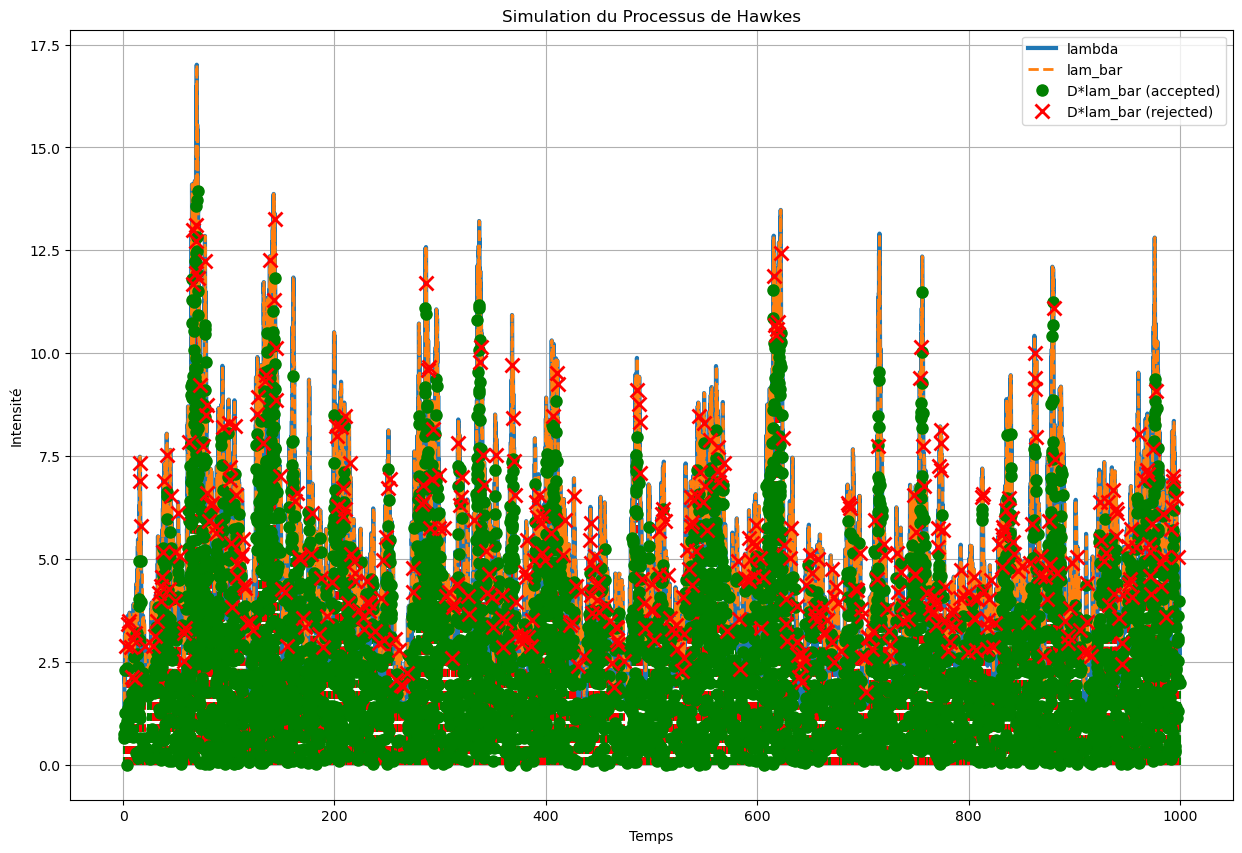

In [12]:
# On reprend notre algorithme d'Ogata définit plus haut ainsi que tous les paramètres d'affichage  avec juste une modification avec Tmax=1000
Tmax = 1000 # On change juste le temps maximum, en effet lors de tests, on a remarqué que plus Tmax était grand, meilleur était l'approximation des paramètres

mu = 1.2
alpha = 0.6
beta = 0.8
TH,DH,TH_R,RH, D= Hawkes_Process(mu, alpha, beta, Tmax) #On utilise notre algorithme avec ces paramètres

# On veut tracer la fonction d'intensité du processus de Hawkes, lamdba(t):
times=np.linspace(0,Tmax,Tmax*100)
l=[] ; sup_l = []; brk2 = []
j=0; count =0
for i in times:
    count +=1
    if j < len(TH)-1:   # Pour s'assurer qu'on ne dépasse pas le nombre de temps de sauts du processus de Hawkes
        if i < TH[0]:   # Tant qu'on a pas eu le 1er saut de temps accepté
            temp = mu   # Notre fonction lamdba reste constante et vaut mu en attendant d'avoir un premier évènement et donc un premier saut de temps
        elif i < TH[j]: # Sinon tant qu'on est entre deux temps de sauts tau on calcule notre lamdba
            temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:j]))))
        else :          # Dans le cas où on a dépassé un temps de sauts
            brk2.append(count-1) # On stocke l'indice de temps de sauts pour s'en servir pour l'affichage du sup de lambda donc de lamdba_bar
            j=j+1                # On passe au temps de sauts suivant
            temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:j]))))
        l.append(temp)
    else: #Une fois qu'on a dépassé le dernier temps de sauts, on prend la dernière valeur du temps de sauts et on calcule lambda jusqu'à la fin de la fenêtre de temps
        temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH[:-1]))))
        l.append(temp)


        
# On veut tracer le sup de la fonction lambda(t) précédente, lamdba_bar:
brk=[] # Pour stocker les temps où l'on doit recalculer le sup de lamdba
b=0
j=0
i=0

brk_rejete = [int(x*100) for x in TH_R] # On récupère les temps tau des points rejetés. On multiple par 100 car on a 1000 points sur l'intervalle [0,Tmax=10] donc on multiple par 100 pour arriver à [0,1000] 
#print(brk_rejete)
#print(brk2)
brk=brk2+brk_rejete # On concatène la liste des tau acceptés et celle des tau rejetés
brk=sorted(brk)     # On la trie par ordre croissant

for j in range(len(brk)): # On parcourt la liste des temps tau acceptés comme refusés
    while i < brk[j]:     # Tant qu'on est entre deux temps de sauts on garde le même sup
        sup_l.append(max(l[b:brk[j]])) # On prend le max de lamdba sur l'intervalle du dernier temps de saut au prochain 
        i+=1
    b=brk[j]    # On actualise le dernier temps de saut, tau
while i < len(l): # Quand on a dépassé le dernier temps de sauts tau, on boucle jusqu'au dernier point de lamdba
    sup_l.append(max(l[brk[-1]:len(l)-1])) # On calcule le sup sur ce dernier intervalle
    i+=1


fig = plt.figure(figsize = (15, 10))

#On veut afficher des lignes verticales à chaque tau acceptés et refusé
count=0
for i in TH: # On parcourt la liste des taus accepté
    if count < len(DH):
        plt.plot([i, i], [0, DH[count]], 'g--') #on trace une ligne en pointillée verte verticale partant du point (x=tau accepté, y=0), jusqu'au point (x=tau accepté, y=D*lamdba_bar) 
        count+=1
    #plt.axvline(x=i, linestyle='--', color='green', linewidth=1)
count=0
for j in TH_R:  # On parcourt la liste des taus refusés
    if count < len(RH):
        plt.plot([j, j], [0, RH[count]], 'r--') #on trace une ligne en pointillée rouge verticale partant du point (x=tau refusé, y=0), jusqu'au point (x=tau refusé, y=D*lamdba_bar) 
        count+=1
    #plt.axvline(x=j, linestyle='--', color='red', linewidth=1)

plt.plot(times, l,label="lambda", linewidth=3)                        # On affiche la fonction d'intensité du Processus de Hawkes lamdba en bleue
plt.plot(times, sup_l, linestyle='--', label="lam_bar",linewidth=2)   # On affiche le sup de lamdba ci-dessus en pointillé orange

plt.plot(TH,DH, "o",color='green', markersize=8, label="D*lam_bar (accepted)")                        # On affiche le critère d'acceptation des tau acceptés, représentés part un cercle vert
plt.plot(TH_R,RH, "x",color='red', markersize=10, markeredgewidth=2, label="D*lam_bar (rejected)")    # On affiche le critère d'acceptation des tau refusés, représentés part une croix rouge
#TH2=TH+TH_R
#TH2=sorted(TH2)

#plt.plot(TH2, D,"^",color='blue', markersize=6, label="D ~ uniform(0,1)")       # On affiche la variable aléatoire D suivant une uniforme(0,1) qui a été utilisée pour le calcul du critère d'acceptation
plt.xlabel('Temps')
plt.ylabel('Intensité')
plt.title('Simulation du Processus de Hawkes')
plt.legend()
plt.grid(True)
plt.show()

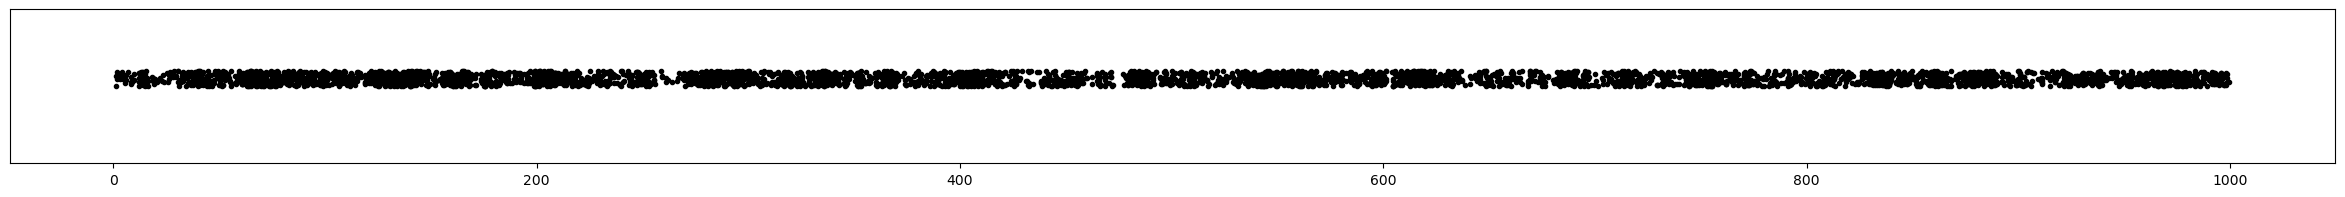

In [13]:
plt.figure(figsize=(30,2))
plt.ylim([-5, 5])
plt.yticks([])
_ = plt.plot(TH, np.random.rand(len(TH)), 'k.')

In [14]:
uv2 = UVHP()
#uv2.set_params(1.2,0.6,0.8)
uv2.fit(np.array(TH))
print(TH[-1])

999.6656314444025


In [15]:
# verify that the unconditional mean makes sense
mu, alpha, beta = uv2.get_params()

N_approx = mu * TH[-1] / (1 - alpha)

print(N_approx)
print(len(TH))
print("alpha:",alpha)
print("mu:",mu)
print("beta:",beta)

4996.436161128569
4986
alpha: 0.735307271556102
mu: 1.3229626771043295
beta: 0.8846518812713163


**Interprétation :**
- On remarque en faisant varier Tmax, que plus il est grand, plus il y a  d'événements donc plus il y a de temps de sauts. Ainsi, l'estimation de nos paramètres est meilleure, ici on pose $T_{max}=1000$.

- On remarque donc qu'on approche bien les valeurs connues d'$\alpha$, de $\mu$, et de $\beta$, en donnant ce processus de Hawkes à la librairie *hawkeslib*.

Ainsi si l'on donne un processus de Hawkes pour lequel on veut estimer les paramètres, si l'on fait en sorte d'avoir un grand nombre de temps de sauts et donc d'évènements, on peut approximativement bien retrouver nos paramètres de départ.

### Retour sur notre processus de comptage issu des données CAC40 - Modélisation

Après s'être familiarisé un peu avec la librairie *hawkeslib*, nous revenons à notre jeu de données du CAC40.

In [ ]:
#On charge les temps de sauts tau sur les 3 jeux de données sur un, deux et cinqs années.
days,T,ind_1,ind_2,ind_seuil,TH_1an=compt(seuil=0.005,CAC40=CAC40_1an)
days,T,ind_1,ind_2,ind_seuil,TH_2an=compt(seuil=0.01,CAC40=CAC40_2an)
days,T,ind_1,ind_2,ind_seuil,TH_5an=compt(seuil=0.01,CAC40=CAC40_5an)

TH_CAC40=TH_2an

#### **Test de Kolmogorov Smirnoff Lilliefors** - Modélisation par un Processus de Poisson Homogène
On intuite que l'on a probablement pas un processus de Poisson Homogène. En effet, les évènements, donc les dépassements de seuils semblent être liés à une fonction d'intensité non constante. De plus, on pourrait penser retrouver un phénomène d'emballement et de répliques après l'occurrence d'un événement, ce qui pourrait nous faire plus penser à un Hawkes. Mais l'on veut s'en assurer en testant, en premier lieu, s'il existe un paramètre $\lambda_{poiss}$ tel que le processus de comptage du CAC40 puisse être modélisé par un processus de Poisson Homogène de paramètre $\lambda_{poiss}$.

Pour ce faire, on veut tester si les inter-sauts suivent une loi exponentielle. Cependant, nous ne connaissons pas le paramètre de cette éventuelle loi exponentielle, ainsi il nous faut réaliser un test d'ajustement de Kolmogorov-Smirnoff corrigé par Lilliefors sur ces inter-sauts.

Pour interpréter ce test, nous savons qu'une p-valeur inférieure à 5% nous indiquerait qu'on rejette à 95% l'hypothèse disant que les inter-sauts suivent une loi exponentielle. Ainsi, on pourrait confirmer notre intuition, en disant que notre processus n'est pas un processus de Poisson Homogène.

In [17]:
inter_saut=[] 
for i in range(0,len(TH_CAC40)-1):
    inter_saut.append(TH_CAC40[i+1]-TH_CAC40[i]) # On soustrait chaque temps tau avec le suivant pour avoir le temps entre deux sauts 
#print(inter_saut)

#Test d'ajustement de Kolmogorov Smirnoff Lilliefors
ksstat, pvalue = sm.stats.diagnostic.lilliefors(inter_saut,"exp",'approx')
print("La stat de test est :",ksstat)
print("La p_value du test est ", pvalue)

alpha=0.05
if pvalue > alpha:
    result = 'Inter-Saut Exponentiel => Processus de Poisson Homogène'
else:
    result = 'Inter-Saut non-Exponentiel => Pas un Processus de Poisson Homogène'
print(f'Lilliefors: {result:>21s}')

La stat de test est : 0.21898356896690632
La p_value du test est  0.0009999999999998899
Lilliefors: Inter-Saut non-Exponentiel => Pas un Processus de Poisson Homogène


#### **Estimation des paramètres avec Hawkeslib** - Modélisation par un Processus de Hawkes

Après avoir effectué un test de Kolmogorov Smirnoff corrigé par Lilliefors, nous pouvons en déduire que notre fonction de comptage ne peut pas être modélisée par un processus de Poisson Homogène. Nous nous intéressons donc désormais au processus de Hawkes. Ce processus pourrait convenir et donc expliquer cette impression d'emballement que l'on croit retrouver lors de l'analyse visuelle des graphiques du processus de comptage.

Pour cela, nous allons donc donner les temps de sauts à la librairie *hawkeslib* et essayer d'interpréter ces résultats, maintenant que nous nous sommes un peu familiarisés avec les commandes.

In [18]:
uv3 = UVHP()
uv3.fit(np.array(TH_CAC40))

-212.03691901405313

In [19]:
# On récupère les paramètres estimés du Hawkes
mu, alpha, beta = uv3.get_params()

N_approx = mu * TH_CAC40[-1] / (1 - alpha) #pour vérifier que cela fait sens on estime le nombre approximatif de temps sauts 

print("Nombre de temps de sauts approximé:",N_approx)
print("Nombre de temps de sauts réel :", len(TH_CAC40))
print("mu:",mu)
print("alpha:",alpha)
print("beta:",beta)

Nombre de temps de sauts approximé: 88.11297142587782
Nombre de temps de sauts réel : 88
mu: 0.23769552911390074
alpha: 0.028855921026479294
beta: 0.06704211028507955


mu: 0.23769552911390074
alpha: 0.028855921026479294
beta: 0.06704211028507955


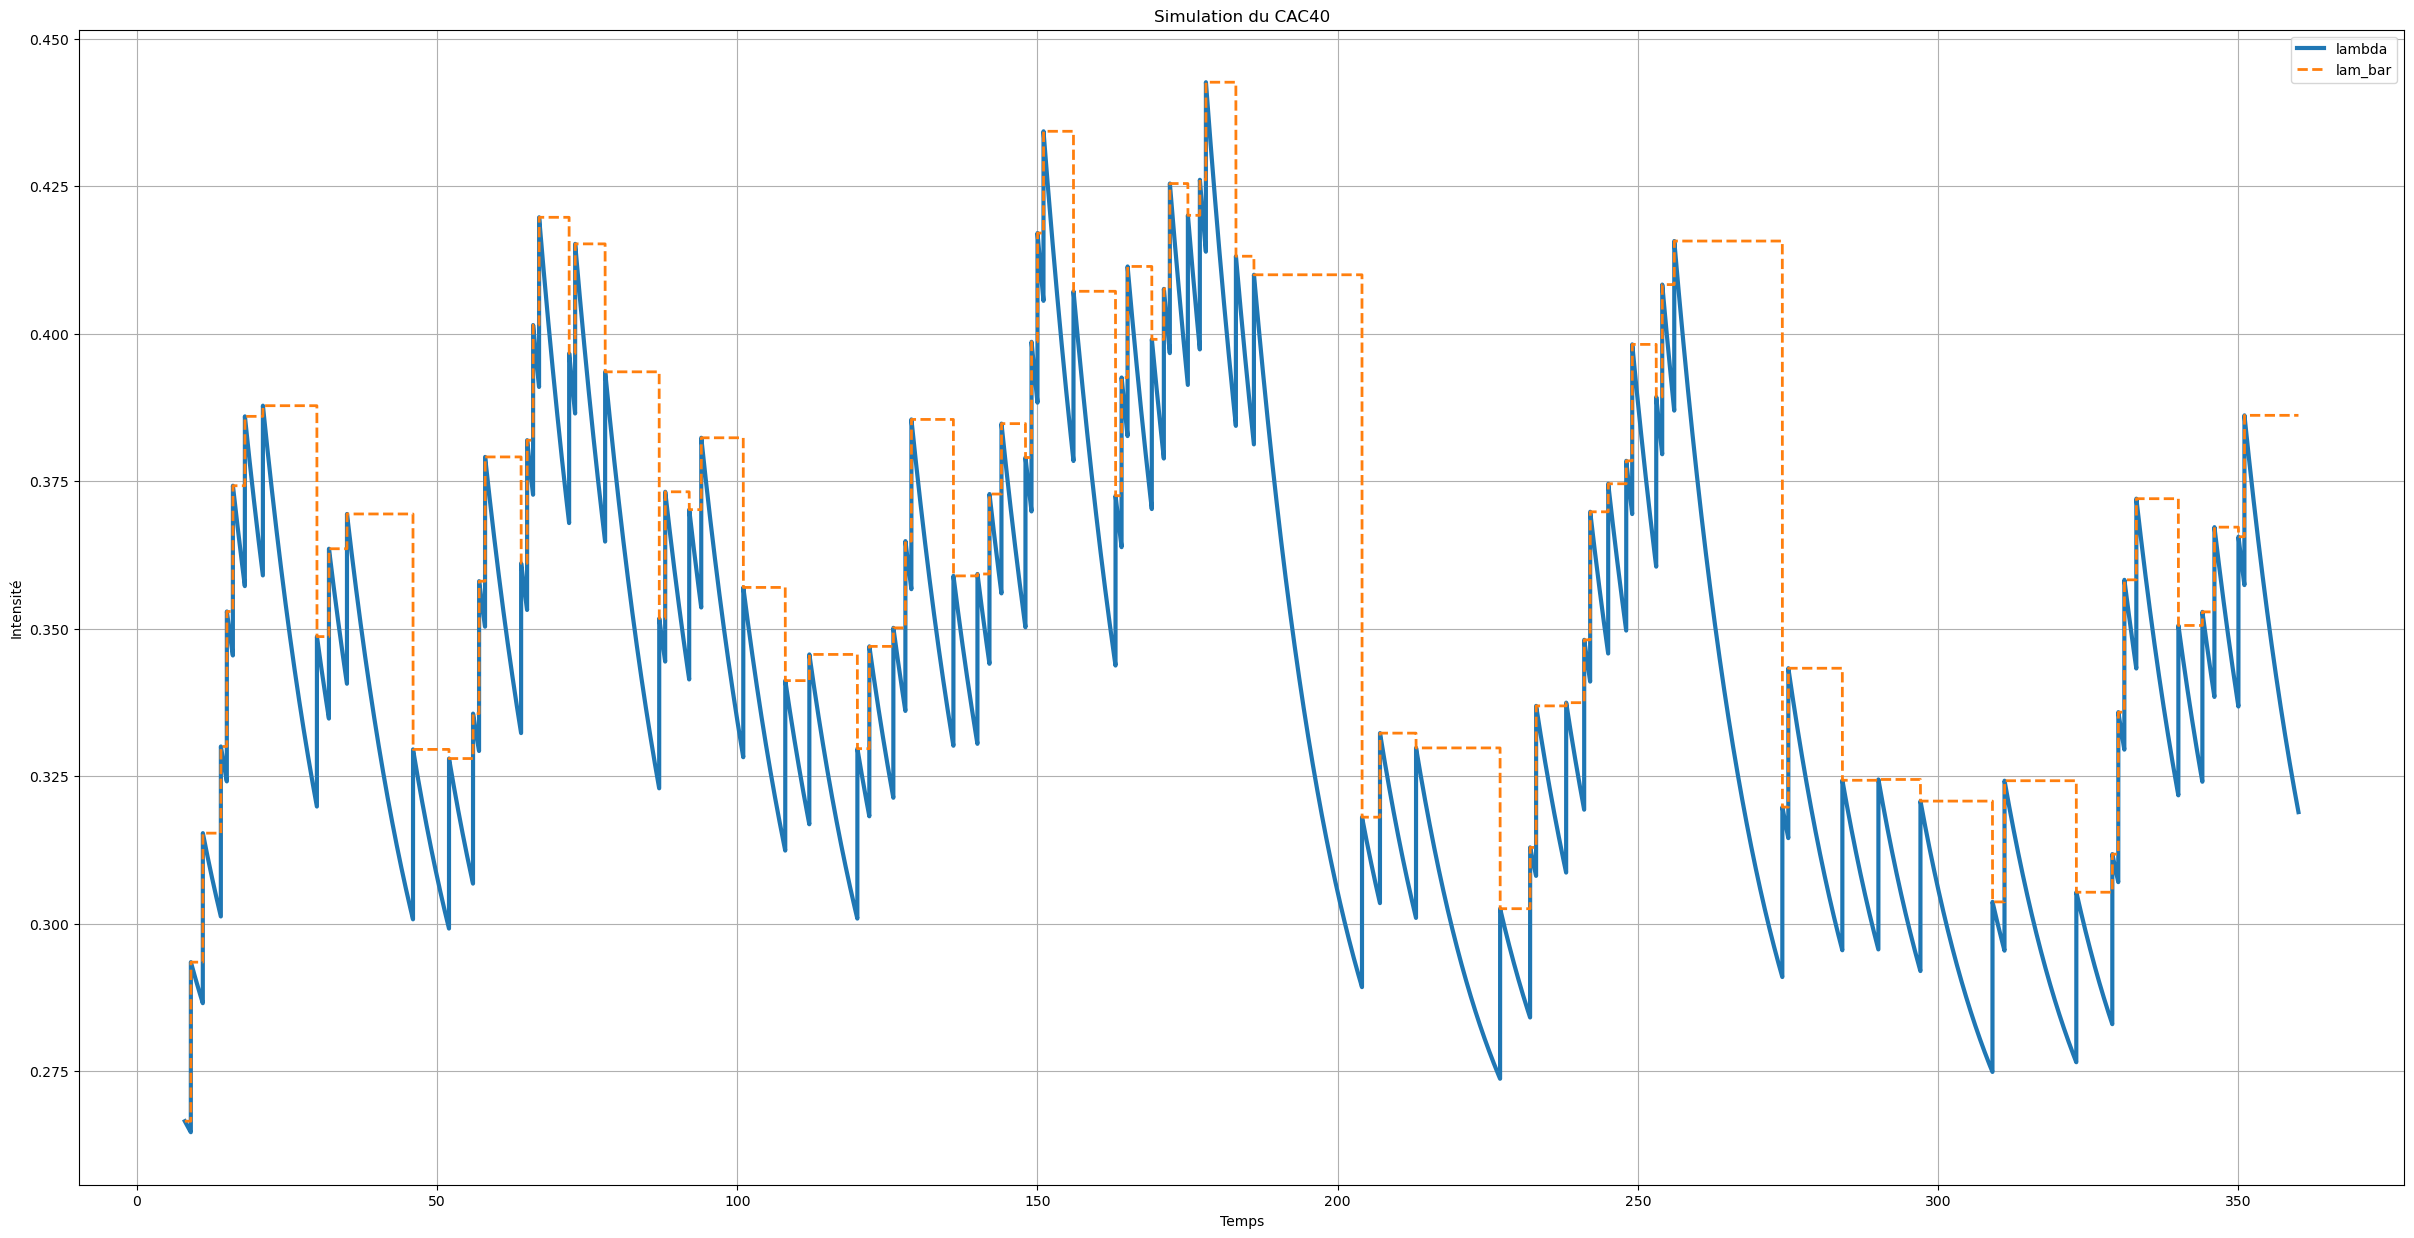

In [21]:
nb_points=int(TH_CAC40[-1])*100
print("mu:",mu)
print("alpha:",alpha)
print("beta:",beta)
# On veut tracer la fonction d'intensité du processus de Hawkes, lamdba(t):
times=np.linspace(TH_CAC40[0],TH_CAC40[-1],nb_points)


l=[] ; sup_l = []; brk2 = []
j=0; count =0
for i in times:
    count +=1
    if j < len(TH_CAC40)-1:   # Pour s'assurer qu'on ne dépasse pas le nombre de temps de sauts du processus de Hawkes
        if i < TH_CAC40[0]:   # Tant qu'on a pas eu le 1er saut de temps accepté
            temp = mu   # Notre fonction lamdba reste constante et vaut mu en attendant d'avoir un premier évènement et donc un premier saut de temps
        elif i < TH_CAC40[j]: # Sinon tant qu'on est entre deux temps de sauts tau on calcule notre lamdba
            temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH_CAC40[:j]))))
        else :          # Dans le cas où on a dépassé un temps de sauts
            brk2.append(count-1) # On stocke l'indice de temps de sauts pour s'en servir pour l'affichage du sup de lambda donc de lamdba_bar
            j=j+1                # On passe au temps de sauts suivant
            temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH_CAC40[:j]))))
        l.append(temp)
    else: #Une fois qu'on a dépassé le dernier temps de sauts, on prend la dernière valeur du temps de sauts et on calcule lambda jusqu'à la fin de la fenêtre de temps
        temp = mu + np.sum(alpha * np.exp(-beta * (i - np.array(TH_CAC40[:-1]))))
        l.append(temp)


        
# On veut tracer le sup de la fonction lambda(t) précédente, lamdba_bar:
b=0
j=0
i=0
brk=sorted(brk2)     # On la trie par ordre croissant

for j in range(len(brk)): # On parcourt la liste des temps tau acceptés comme refusés
    while i < brk[j]:     # Tant qu'on est entre deux temps de sauts on garde le même sup
        sup_l.append(max(l[b:brk[j]])) # On prend le max de lamdba sur l'intervalle du dernier temps de saut au suivant 
        i+=1
    b=brk[j]    # On actualise le dernier temps de sauts, tau
while i < len(l): # Quand on a dépassé le dernier temps de sauts tau, on boucle jusqu'au dernier point de lamdba
    sup_l.append(max(l[brk[-1]:len(l)-1])) # On calcule le sup sur ce dernier intervalle
    i+=1



fig = plt.figure(figsize = (30, 15))

plt.plot(times, l,label="lambda", linewidth=3)                        # On affiche la fonction d'intensité du Processus de Hawkes lamdba en bleue
plt.plot(times, sup_l, linestyle='--', label="lam_bar",linewidth=2)   # On affiche le sup de lamdba ci-dessus en pointillé orange
plt.xlabel('Temps')
plt.ylabel('Intensité')
plt.title('Simulation du CAC40')
plt.legend()
plt.grid(True)
plt.show()

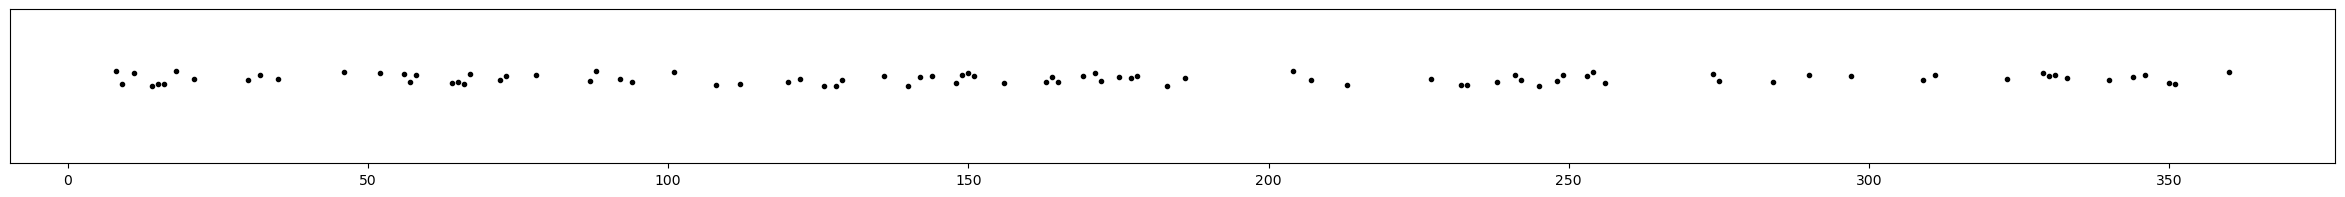

In [22]:
plt.figure(figsize=(30,2))
plt.ylim([-5, 5])
plt.yticks([])
_ = plt.plot(TH_CAC40, np.random.rand(len(TH_CAC40)), 'k.')

In [23]:
uv = UVHP()
uv.fit(np.array(TH_1an))
mu, alpha, beta = uv.get_params()

N_approx = mu * TH_1an[-1] / (1 - alpha)
print("---------CAC 40 sur une période d'1 an----------------")
print("Nombre de temps de sauts approximé :",N_approx)
print("Nombre de temps de sauts réel :", len(TH_1an))
print("mu:",mu)
print("alpha:",alpha)
print("beta:",beta)


uv = UVHP()
uv.fit(np.array(TH_2an))
mu, alpha, beta = uv.get_params()

N_approx = mu * TH_2an[-1] / (1 - alpha)
print(" ")
print("---------CAC 40 sur une période de 2 ans---------------")
print("Nombre de temps de sauts approximé :",N_approx)
print("Nombre de temps de sauts réel :", len(TH_2an))
print("mu:",mu)
print("alpha:",alpha)
print("beta:",beta)


uv = UVHP()
uv.fit(np.array(TH_5an))
mu, alpha, beta = uv.get_params()

N_approx = mu * TH_5an[-1] / (1 - alpha)
print(" ")
print("---------CAC 40 sur une période de 5 ans---------------")
print("Nombre de temps de sauts approximé :",N_approx)
print("Nombre de temps de sauts réel :", len(TH_5an))
print("mu:",mu)
print("alpha:",alpha)
print("beta:",beta)

---------CAC 40 sur une période d'1 an----------------
Nombre de temps de sauts approximé: 88.10514269403224
Nombre de temps de sauts réel : 88
mu: 0.23784021978021808
alpha: 0.02817841839012076
beta: 0.070456340745596
 
---------CAC 40 sur une période de 2 ans---------------
Nombre de temps de sauts approximé: 211.82619619086233
Nombre de temps de sauts réel : 211
mu: 0.2234966718587397
alpha: 0.23189114453738557
beta: 0.08271684870972225
 
---------CAC 40 sur une période de 5 ans---------------
Nombre de temps de sauts approximé: 273.0796921630938
Nombre de temps de sauts réel : 271
mu: 0.0597452254185617
alpha: 0.6037837805661695
beta: 0.062161491202914865


**Interprétation :**
- **Pour le jeu de données sur 1 an :**  Même en variant notre seuil, nous observons un $\alpha$ proche de 0, ce qui pourrait suggérer un processus de Poisson homogène. Cependant, cette hypothèse a été rejetée par le test de Lilliefors. Ainsi, on peut conclure que pour cette année, avec ces valeurs de seuils, le CAC 40 n'a pas montré de véritables effets d'emballement et de répliques après un dépassement de seuil.

- **Pour le jeu de données sur 2 ans :** On remarque que la valeur de notre seuil est assez impactante :

    - Seuil à 1% : Avec un seuil à 1%, nous acceptons à 95% l'hypothèse que les inter-sauts suivent une loi exponentielle, validant ainsi l'hypothèse que le processus de comptage pourrait être modélisé par un Poisson homogène. Cependant, la forme de la fonction de comptage suggère le contraire.
    
    - Seuil à 0,5% : Nous avons abaissé le seuil à 0,5% pour obtenir plus de temps de sauts, afin de voir si cela impacte le test de Lilliefors et parce que, d'après nos premières analyses avec la librairie Hawkeslib, un grand nombre de sauts permet de mieux approximer et estimer les paramètres d'un processus de Hawkes.
    
Avec ce nouveau seuil, nous rejetons l'hypothèse d'un processus de Poisson homogène. De plus, la librairie 'Hawkeslib' nous donne un $\alpha$ d'environ 0,2, indiquant un petit facteur d'emballement, et un paramètre $\beta$ de 0,08, qui est assez bas. Cela signifie que ce processus de Hawkes maintient une intensité importante longtemps après un événement. 

*Rq: Nous obtenons les mêmes résultats avec un seuil de 1%, confirmant ainsi notre intuition initiale.*

- **Pour le jeu de données sur 5 ans :** Avec un seuil de 1% ou de 2%, les résultats sont similaires. Un seuil de 2% montre visuellement un processus de Hawkes, tandis qu'un seuil de 1% produit trop de points pour être interprétable à l'œil nu. Dans les deux cas, nous rejetons l'hypothèse d'un processus de Poisson et estimons un  $\alpha$ d'environ 0,6, indiquant un facteur d'emballement conséquent. Le paramètre $\beta$ reste à 0,08, comme pour les données sur 2 ans, signifiant que le processus de Hawkes garde une intensité importante longtemps après un événement.




**Résilience :** 

Nous constatons que les processus de Hawkes montrent des intensités importantes longtemps après un événement, et des sauts d'intensité variables à chaque événement. Cela permet d'évaluer la résilience du CAC 40, c'est-à-dire sa capacité à encaisser les chocs. Cette résilience est ici vue par la capacité du cours du CAC40 à ne pas avoir des rendements qui s'emballent dès lors qu'ils dépassent un seuil donné. Or ici, comme notre intensité n'a pas une forte décroissance exponentielle, due à $\beta$ petit, cela veut dire que la stabilité du CAC40 est assez faible si on compare le rendement avec un seuil de 1%. Cependant, si l'on regarde le cours d'une entreprise précise en bourse, elle devrait avoir une résilience encore bien plus basse et instable, car le CAC40 se base sur les 40 plus grosses entreprises françaises, il est théoriquement plus stable. Cela est tout de même visible car nous observons ici des dépassements du seuil assez faible, de l'ordre de 1%, assez rare sur nos périodes de données. Par exemple, sur 5 ans, le seuil a été dépassé 271 fois sur 1280 jours de bourse.

En examinant les 5 dernières années, nous voyons que le paramètre 
$\alpha$
α est plus élevé que sur les 2 dernières années, suggérant une résilience plus forte sur les 2 dernières années. Un 
$\alpha$
α plus élevé implique des sauts d'intensité plus élevés et un risque accru d'emballement après un dépassement de seuil. Les 5 dernières années incluent des événements majeurs comme la pandémie de COVID-19 avec une grosse chute du cours en Février/Mars 2020 et une augmentation plus lente pour revenir au niveau d'avant crise sanitaire en Mars 2021. Cependant ces 2 dernières années comprennent aussi des événements géopolitiques impactant comme la guerre en Ukraine qui ont fait fluctuer le cours de la Bourse et du CAC 40.

## ***BIBLIOGRAPHIE :***
- *Thinning Algorithms for Simulating Point Processes*, Yuanda Chen
- *Poisson processes and application to reliability theory and actuarial science*, Mélisande ALBERT
- *Cours sur les processus de poissons*, Université de Rennes, Jérémy Bettinger & Simon Viel
- *Processus de Poisson homogènes - Application à des données génomiques*, Mélisande ALBERT & Nicolas OGOREK
